In [85]:
!pip install pmdarima
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import warnings
import io
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error



In [65]:
from google.colab import files


uploaded = files.upload()

Saving Bitcoin Data.csv to Bitcoin Data (1).csv


In [66]:
data = pd.read_csv(io.BytesIO(uploaded['Bitcoin Data.csv']),parse_dates=["Date"], index_col="Date")
print(data)

              Close     Open     High      Low     Vol
Date                                                  
2021-06-01  36687.6  37294.3  37850.3  35742.7  113480
2021-06-02  37555.8  36687.7  38199.9  35981.1   96890
2021-06-03  39187.3  37555.7  39462.3  37193.6  106440
2021-06-04  36851.3  39191.4  39255.4  35659.9  127710
2021-06-05  35520.0  36841.2  37887.6  34832.0  101480
...             ...      ...      ...      ...     ...
2023-05-28  28071.2  26855.3  28181.9  26788.5   55230
2023-05-29  27739.4  28068.4  28431.2  27548.8   54560
2023-05-30  27698.2  27738.9  28033.6  27583.8   45190
2023-05-31  27216.1  27696.9  27825.0  26865.1   63080
2023-06-01  26819.0  27216.4  27340.9  26662.3   51980

[731 rows x 5 columns]


In [69]:
ts =data[['Close']]
display(ts.shape)
print(ts.head())
print('Timeseries Range => ', ts.index.min(), ' - ' , ts.index.max())

(731, 1)

              Close
Date               
2021-06-01  36687.6
2021-06-02  37555.8
2021-06-03  39187.3
2021-06-04  36851.3
2021-06-05  35520.0
Timeseries Range =>  2021-06-01 00:00:00  -  2023-06-01 00:00:00


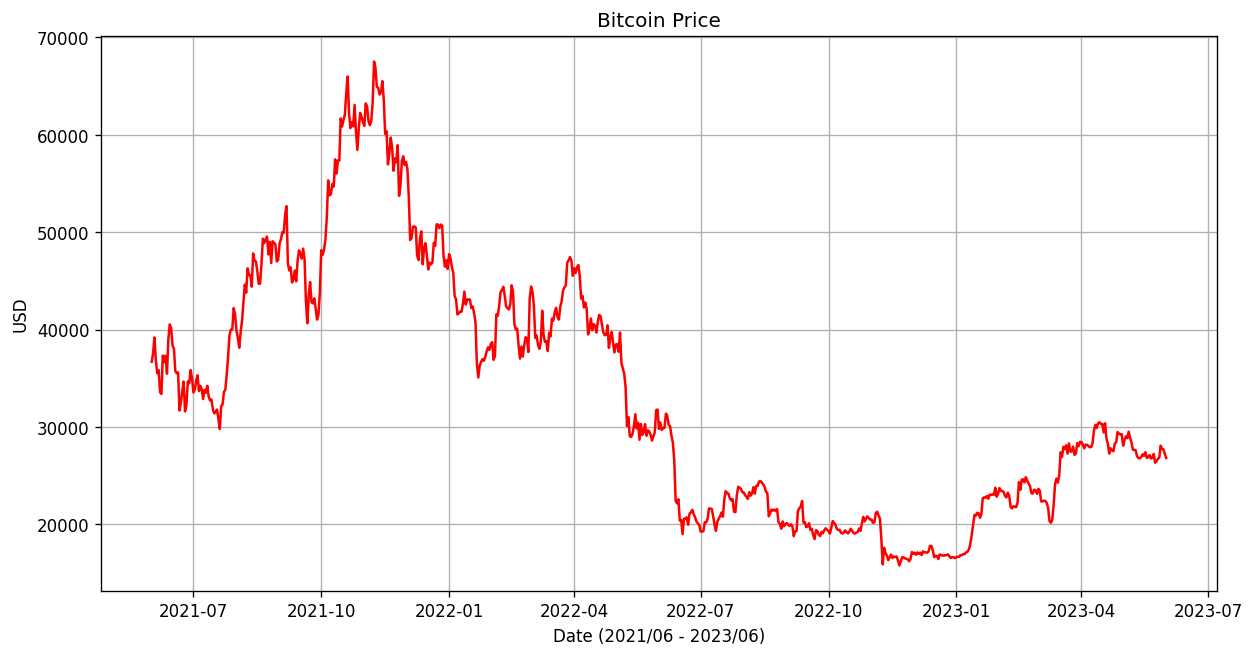

In [70]:
def draw_ts_plot(timeseries, xlabel ='Date', ylabel ='Close', title ="", dpi=120):
    plt.figure(figsize=(12,6),dpi=dpi)
    plt.plot(timeseries, color='red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.grid(True)
    plt.show()

draw_ts_plot(ts, xlabel="Date (2021/06 - 2023/06)", ylabel = "USD", title="Bitcoin Price")

## based models comparisons 7-2-1 split


In [ ]:

# Đọc dữ liệu giá Bitcoin từ file CSV
data = pd.read_csv('Bitcoin Data.csv')

# Chuyển đổi cột thời gian sang định dạng ngày-tháng
data['Date'] = pd.to_datetime(data['Date'])

# Đặt cột thời gian làm chỉ mục cho dữ liệu
data.set_index('Date', inplace=True)


In [108]:
# 2. Đọc file dữ liệu  và chia train test validate theo tỉ lệ 7:1:2
df = data[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df_index = df.index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(511, 1)
(146, 1)
(74, 1)


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima


# Tìm kiếm mô hình SARIMAX tốt nhất
model = auto_arima(train_data['Close'], seasonal=True, m=12)

# Xây dựng mô hình SARIMAX tốt nhất
order = model.order
seasonal_order = model.seasonal_order
final_model = SARIMAX(train_data['Close'], order=order, seasonal_order=seasonal_order)
final_model.fit(train_data)

In [125]:
order

(0, 1, 0)

In [127]:
# Xây dựng mô hình SARIMAX
model = SARIMAX(train_data, order = order, seasonal_order=(1, 1, 1, 12))

model_fit = model.fit()

print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  511
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -4381.152
Date:                              Mon, 19 Jun 2023   AIC                           8768.305
Time:                                      21:33:22   BIC                           8780.937
Sample:                                           0   HQIC                          8773.262
                                              - 511                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2533      0.023     11.204      0.000       0.209       0.298
ma.S.L12      -0.96

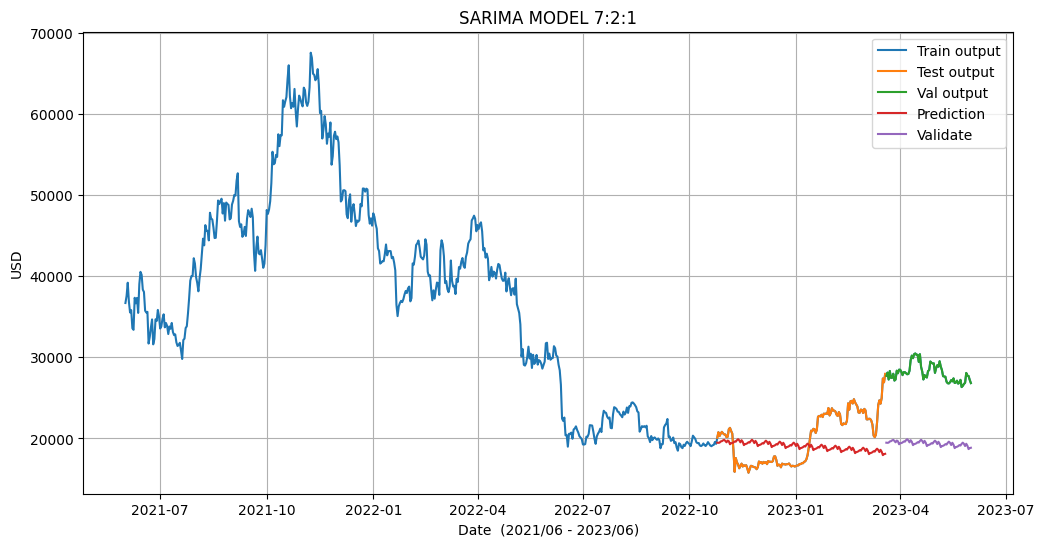

In [128]:
# Dự đoán giá trị cho tập test data và validation data
test_forecast = model_fit.forecast(steps=len(test_data))
val_forecast = model_fit.forecast(steps=len(val_data))
train_forecast = model_fit.forecast(steps=len(train_data))

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(date, close, label='Train output')
plt.plot(date[train_size:train_size+test_size], test_data, label='Test output')
plt.plot(date[train_size+test_size:], val_data, label='Val output')
plt.plot(date[train_size:train_size+test_size],test_forecast,  label='Prediction')
plt.plot(date[train_size+test_size:],val_forecast,  label='Validate')

plt.title('SARIMA MODEL 7:2:1')
plt.xlabel('Date  (2021/06 - 2023/06)')
plt.ylabel('USD')
plt.legend()
plt.show()


In [129]:
# Tính RMSE, MAPE cho test data
rmse_test = np.sqrt(mean_squared_error(test_data, test_forecast))
mape_test = mean_absolute_percentage_error(test_data, test_forecast)

# Tính RMSE, MAPE cho val data
rmse_val = np.sqrt(mean_squared_error(val_data, val_forecast))
mape_val = mean_absolute_percentage_error(val_data, val_forecast)

print('-TEST-')
print(f"RMSE Test: {rmse_test:.2f}")
print(f"MAPE Test: {mape_test * 100:.2f}%")
print('-VALID-')
print(f"RMSE Val: { rmse_val:.2f}")
print(f"MAPE Val: {mape_val * 100:.2f}%")




-TEST-
RMSE Test: 3581.26
MAPE Test: 15.47%
-VALID-
RMSE Val: 8745.58
MAPE Val: 30.84%


## based models comparisons 6-2-2 split


(438, 1)
(146, 1)
(147, 1)
                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  438
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -3769.452
Date:                              Mon, 19 Jun 2023   AIC                           7544.904
Time:                                      21:41:08   BIC                           7557.061
Sample:                                           0   HQIC                          7549.707
                                              - 438                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2704      0.026     10.325      0.000       0.219     

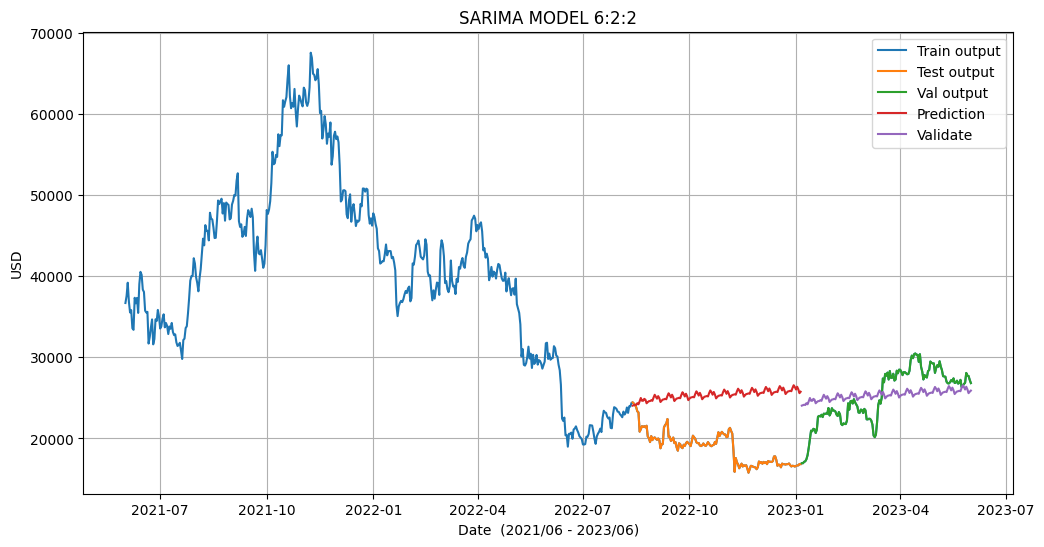

In [135]:

# Đọc dữ liệu giá Bitcoin từ file CSV
data = pd.read_csv('Bitcoin Data.csv')

# Chuyển đổi cột thời gian sang định dạng ngày-tháng
data['Date'] = pd.to_datetime(data['Date'])

# Đặt cột thời gian làm chỉ mục cho dữ liệu
data.set_index('Date', inplace=True)

# 2. Đọc file dữ liệu  và chia train test validate theo tỉ lệ 7:1:2
df = data[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df_index = df.index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)


# Tìm kiếm mô hình SARIMAX tốt nhất
model = auto_arima(train_data['Close'], seasonal=True, m=12)

# Xây dựng mô hình SARIMAX tốt nhất
order = model.order
seasonal_order = model.seasonal_order
final_model = SARIMAX(train_data['Close'], order=order, seasonal_order=seasonal_order)
final_model.fit(train_data)

# Xây dựng mô hình SARIMAX
model = SARIMAX(train_data, order = order, seasonal_order=(1, 1, 1, 12))

model_fit = model.fit()

print(model_fit.summary())

# Dự đoán giá trị cho tập test data và validation data
test_forecast = model_fit.forecast(steps=len(test_data))
val_forecast = model_fit.forecast(steps=len(val_data))
train_forecast = model_fit.forecast(steps=len(train_data))

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(date, close, label='Train output')
plt.plot(date[train_size:train_size+test_size], test_data, label='Test output')
plt.plot(date[train_size+test_size:], val_data, label='Val output')
plt.plot(date[train_size:train_size+test_size],test_forecast,  label='Prediction')
plt.plot(date[train_size+test_size:],val_forecast,  label='Validate')

plt.title('SARIMA MODEL 6:2:2')
plt.xlabel('Date  (2021/06 - 2023/06)')
plt.ylabel('USD')
plt.legend()
plt.show()


In [136]:
# Tính RMSE, MAPE cho test data
rmse_test = np.sqrt(mean_squared_error(test_data, test_forecast))
mape_test = mean_absolute_percentage_error(test_data, test_forecast)

# Tính RMSE, MAPE cho val data
rmse_val = np.sqrt(mean_squared_error(val_data, val_forecast))
mape_val = mean_absolute_percentage_error(val_data, val_forecast)

print('-TEST-')
print(f"RMSE Test: {rmse_test:.2f}")
print(f"MAPE Test: {mape_test * 100:.2f}%")
print('-VALID-')
print(f"RMSE Val: { rmse_val:.2f}")
print(f"MAPE Val: {mape_val * 100:.2f}%")



-TEST-
RMSE Test: 6950.68
MAPE Test: 36.29%
-VALID-
RMSE Val: 2925.45
MAPE Val: 10.55%


## based models comparisons 8-1-1 split


(584, 1)
(73, 1)
(74, 1)
                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  584
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -4986.936
Date:                              Mon, 19 Jun 2023   AIC                           9979.871
Time:                                      21:42:31   BIC                           9992.913
Sample:                                           0   HQIC                          9984.959
                                              - 584                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2451      0.020     12.116      0.000       0.205       

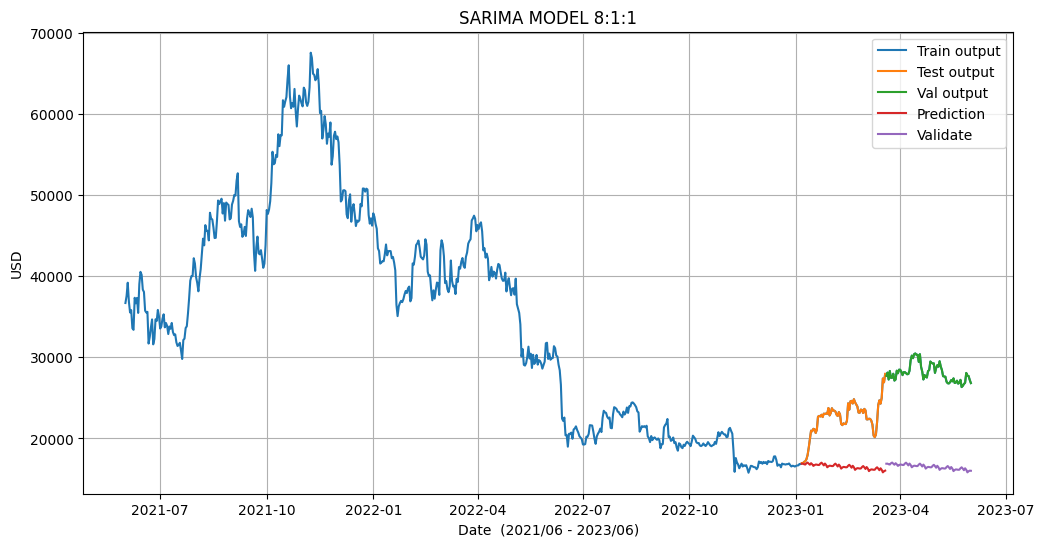

In [140]:
# Đọc dữ liệu giá Bitcoin từ file CSV
data = pd.read_csv('Bitcoin Data.csv')

# Chuyển đổi cột thời gian sang định dạng ngày-tháng
data['Date'] = pd.to_datetime(data['Date'])

# Đặt cột thời gian làm chỉ mục cho dữ liệu
data.set_index('Date', inplace=True)

# 2. Đọc file dữ liệu  và chia train test validate theo tỉ lệ 7:1:2
df = data[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df_index = df.index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)


# Tìm kiếm mô hình SARIMAX tốt nhất
model = auto_arima(train_data['Close'], seasonal=True, m=12)

# Xây dựng mô hình SARIMAX tốt nhất
order = model.order
seasonal_order = model.seasonal_order
final_model = SARIMAX(train_data['Close'], order=order, seasonal_order=seasonal_order)
final_model.fit(train_data)

# Xây dựng mô hình SARIMAX
model = SARIMAX(train_data, order = order, seasonal_order=(1, 1, 1, 12))

model_fit = model.fit()

print(model_fit.summary())

# Dự đoán giá trị cho tập test data và validation data
test_forecast = model_fit.forecast(steps=len(test_data))
val_forecast = model_fit.forecast(steps=len(val_data))
train_forecast = model_fit.forecast(steps=len(train_data))

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(date, close, label='Train output')
plt.plot(date[train_size:train_size+test_size], test_data, label='Test output')
plt.plot(date[train_size+test_size:], val_data, label='Val output')
plt.plot(date[train_size:train_size+test_size],test_forecast,  label='Prediction')
plt.plot(date[train_size+test_size:],val_forecast,  label='Validate')

plt.title('SARIMA MODEL 8:1:1')
plt.xlabel('Date  (2021/06 - 2023/06)')
plt.ylabel('USD')
plt.legend()
plt.show()

In [141]:
# Tính RMSE, MAPE cho test data
rmse_test = np.sqrt(mean_squared_error(test_data, test_forecast))
mape_test = mean_absolute_percentage_error(test_data, test_forecast)

# Tính RMSE, MAPE cho val data
rmse_val = np.sqrt(mean_squared_error(val_data, val_forecast))
mape_val = mean_absolute_percentage_error(val_data, val_forecast)

print('-TEST-')
print(f"RMSE Test: {rmse_test:.2f}")
print(f"MAPE Test: {mape_test * 100:.2f}%")
print('-VALID-')
print(f"RMSE Val: { rmse_val:.2f}")
print(f"MAPE Val: {mape_val * 100:.2f}%")



-TEST-
RMSE Test: 6391.66
MAPE Test: 25.59%
-VALID-
RMSE Val: 11604.60
MAPE Val: 41.10%
